In [1]:
# Build a small Pixel CNN++ model to train on MNIST.

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers

# Load MNIST from tensorflow_datasets
data = tfds.load('fashion_mnist')
train_data, test_data = data['train'], data['test']

def image_preprocess(x):
  x['image'] = tf.cast(x['image'], tf.float32)
  return (x['image'],)  # (input, output) of the model

batch_size = 16
train_it = train_data.map(image_preprocess).batch(batch_size).shuffle(1000)

image_shape = (28, 28, 1)
# Define a Pixel CNN network
dist = tfd.PixelCNN(
    image_shape=image_shape,
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=5,
    dropout_p=.3,
)

# Define the model input
image_input = tfkl.Input(shape=image_shape)

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
model = tfk.Model(inputs=image_input, outputs=log_prob)
model.add_loss(-tf.reduce_mean(log_prob))

# Compile and train the model
model.compile(
    optimizer=tfk.optimizers.Adam(.001),
    metrics=[])

model.fit(train_it, epochs=10, verbose=True)

2022-05-26 11:44:33.030930: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

2022-05-26 11:45:04.038230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shuffling /home/gdl/tensorflow_datasets/fashion_mnist/3.0.1.incompleteP84HQ1/fashion_mnist-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /home/gdl/tensorflow_datasets/fashion_mnist/3.0.1.incompleteP84HQ1/fashion_mnist-test.tfrecord*...: …

Dataset fashion_mnist downloaded and prepared to /home/gdl/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Epoch 1/10
3750/3750 [==============================] - 3967s 1s/step - loss: 1684.5781
Epoch 2/10
3750/3750 [==============================] - 4440s 1s/step - loss: 1595.8108
Epoch 3/10
3750/3750 [==============================] - 3499s 933ms/step - loss: 1572.2653
Epoch 4/10
3750/3750 [==============================] - 3367s 898ms/step - loss: 1560.4697
Epoch 5/10
3750/3750 [==============================] - 2863s 763ms/step - loss: 1552.2097
Epoch 6/10
 781/3750 [=====>........................] - ETA: 28:04 - loss: 1542.6068

KeyboardInterrupt: 

In [4]:
# sample images from the trained model
samples = dist.sample(10)

In [5]:
samples.shape

TensorShape([10, 28, 28, 1])

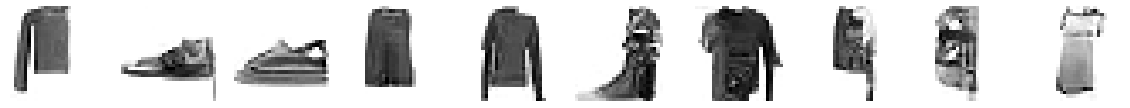

In [6]:
from utils.image import display
display(samples.numpy())

In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (None, 28, 28, 1)    0           ['input_2[0][0]']                
                                                                                                  
 tf.convert_to_tensor_4 (TFOpLa  (None, 28, 28, 1)   0           ['tf.reshape_1[0][0]']           
 mbda)                                                                                            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 28, 28, 1)    0           ['tf.reshape_1[0][0]']     

In [32]:
import numpy as np
preds3 = model.predict(np.concatenate([list(train_it.take(1))[0][0][:1, :14,:,:].numpy(), np.zeros(shape=(1,14,28,1))], axis = 1 ))
# preds3 = np.argmax(preds3, axis = -1)

In [33]:
preds3.shape

(1,)

IndexError: invalid index to scalar variable.

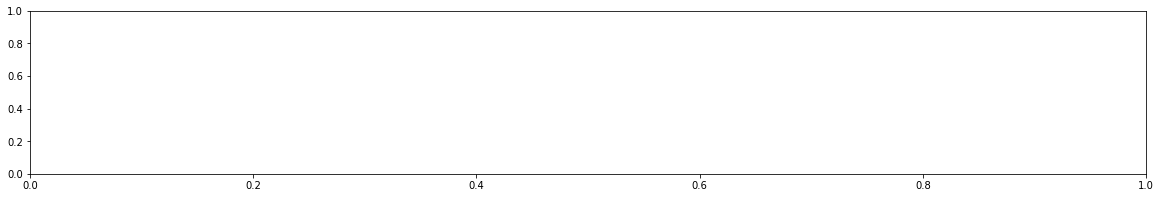

In [30]:
display(preds3, n = 1)